In [17]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import numpy as np
from ast import literal_eval # Library untuk mengubah string list menjadi list sungguhan

# --- 1. Muat Data Anda ---
# Ganti 'nama_file_anda.csv' dengan nama file yang berisi data di atas.
try:
    df = pd.read_csv('hasil_preprocessing_berita.csv') 
    print("File CSV berhasil dimuat.")
except FileNotFoundError:
    print("Error: Pastikan nama file CSV sudah benar dan file berada di folder yang sama dengan notebook Anda.")
    # Hentikan eksekusi jika file tidak ditemukan
    raise

# --- 2. Konversi Kolom 'hasil_preprocessing' dari String ke List ---
# Ini adalah langkah penting untuk data Anda.
nama_kolom_token = 'hasil_preprocessing' 
df[nama_kolom_token] = df[nama_kolom_token].apply(literal_eval)

# Ambil daftar dokumen (yang berisi token) dari DataFrame
documents = df[nama_kolom_token].tolist()


# --- 3. Persiapan untuk Gensim (Dictionary & Corpus) ---
# Membuat kamus
dictionary = Dictionary(documents)

# --- TAMBAHKAN BLOK KODE INI ---
# Filter kata-kata ekstrem untuk membuat topik lebih bersih
# Buang kata yang muncul di kurang dari 5 dokumen
# Buang kata yang muncul di lebih dari 50% total dokumen
dictionary.filter_extremes(no_below=5, no_above=0.5)
# -------------------------------

# Membuat korpus (Bag of Words) - baris ini tetap sama
corpus = [dictionary.doc2bow(doc) for doc in documents]

print(f"\nJumlah kata unik dalam kamus: {len(dictionary)}")
print(f"Jumlah dokumen dalam korpus: {len(corpus)}")




File CSV berhasil dimuat.

Jumlah kata unik dalam kamus: 8283
Jumlah dokumen dalam korpus: 3653


In [31]:
# Letakkan ini di Fase 3, sebelum Anda menjalankan plot koherensi atau melatih LDA final

import gensim

# Pastikan variabel 'corpus' dan 'dictionary' sudah ada

print("--- Memulai Pelatihan Model HDP untuk Estimasi Jumlah Topik ---")

# Inisialisasi dan latih model HDP
# HDP tidak memerlukan parameter num_topics
hdp_model = gensim.models.HdpModel(corpus=corpus, id2word=dictionary)

print("--- Pelatihan HDP Selesai ---")

# Dapatkan topik yang ditemukan oleh HDP
hdp_topics = hdp_model.print_topics()

# Hitung jumlah topik yang berhasil diidentifikasi
estimated_num_topics = len(hdp_topics)

print(f"\nModel HDP mengestimasi ada sekitar: {estimated_num_topics} topik dalam dataset Anda.")

--- Memulai Pelatihan Model HDP untuk Estimasi Jumlah Topik ---


--- Pelatihan HDP Selesai ---

Model HDP mengestimasi ada sekitar: 20 topik dalam dataset Anda.


In [33]:
# Import untuk LDA & Koherensi
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, HdpModel

In [34]:
# --- B. Estimasi Jumlah Topik dengan HDP (Langkah Cerdas) ---
print("\n--- Menjalankan HDP untuk estimasi jumlah topik... ---")
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)
estimated_num_topics = len(hdp_model.print_topics())
print(f"✅ HDP mengestimasi ada sekitar: {estimated_num_topics} topik.")


--- Menjalankan HDP untuk estimasi jumlah topik... ---


✅ HDP mengestimasi ada sekitar: 20 topik.


Selesai menghitung untuk 5 topik...
Selesai menghitung untuk 10 topik...
Selesai menghitung untuk 15 topik...


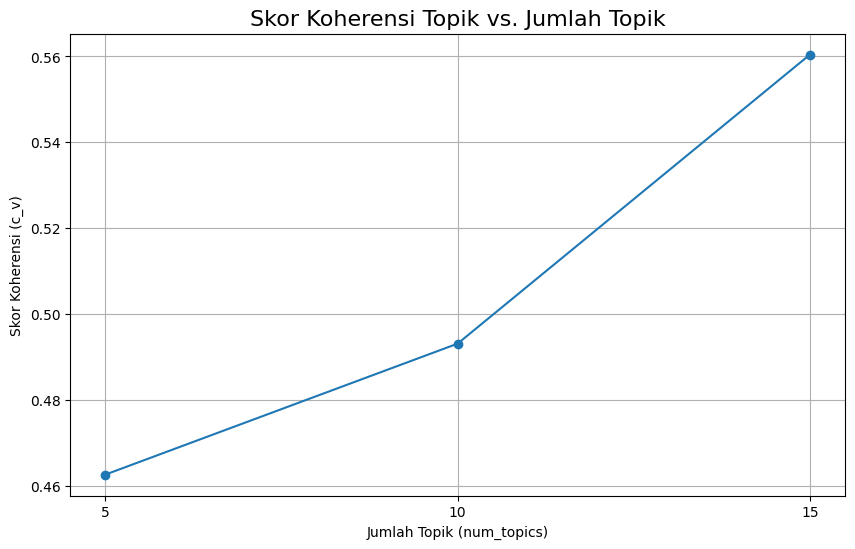

Jumlah Topik = 5, memiliki Skor Koherensi = 0.4626
Jumlah Topik = 10, memiliki Skor Koherensi = 0.4931
Jumlah Topik = 15, memiliki Skor Koherensi = 0.5604


In [23]:
import gensim
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Pastikan variabel dictionary, corpus, dan documents sudah ada dari Fase 3

def compute_coherence_values_multicore(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Menghitung skor koherensi untuk berbagai jumlah topik menggunakan LdaMulticore.
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Menggunakan LdaMulticore untuk pemrosesan paralel yang lebih cepat
        # 'workers' idealnya diatur ke jumlah inti CPU Anda - 1.
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=42,
                                           passes=10,
                                           workers=5) # Ganti angka 3 sesuai jumlah inti CPU Anda
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(f"Selesai menghitung untuk {num_topics} topik...") # Penanda progres

    return model_list, coherence_values

# --- Jalankan Fungsi ---
# Anda bisa mengatur 'limit' dan 'step' sesuai kebutuhan.
# limit=50 dan step=5 adalah awal yang baik.
limit = 20
start = 5
step = 5

model_list, coherence_values = compute_coherence_values_multicore(
    dictionary=dictionary, 
    corpus=corpus, 
    texts=documents, 
    start=start, 
    limit=limit, 
    step=step
)

# --- Tampilkan Grafik Hasilnya ---
x = range(start, limit, step)
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values, marker='o')
plt.title("Skor Koherensi Topik vs. Jumlah Topik", fontsize=16)
plt.xlabel("Jumlah Topik (num_topics)")
plt.ylabel("Skor Koherensi (c_v)")
plt.xticks(x)
plt.grid(True)
plt.show()

# --- Cetak Nilai Skor ---
for m, cv in zip(x, coherence_values):
    print(f"Jumlah Topik = {m}, memiliki Skor Koherensi = {round(cv, 4)}")

In [24]:
# --- 4. Melatih Model LDA ---
# Tentukan jumlah topik. 
# SARAN: Coba set angka ini sama dengan jumlah total kategori unik yang Anda miliki di seluruh dataset.
# Misalnya, jika Anda punya kategori 'Jatim', 'Nasional', 'Olahraga', 'Ekonomi', maka NUM_TOPICS = 4
NUM_TOPICS = 15 # Ganti angka ini sesuai kebutuhan Anda

lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=NUM_TOPICS,
                     random_state=42,
                     passes=10)


# --- 5. Melihat Hasil Topik ---
print("\nTopik yang ditemukan oleh LDA:")
for idx, topic in lda_model.print_topics(-1):
    print(f'Topik: {idx} \nKata-kata: {topic}\n')


# --- 6. Ekstraksi Fitur untuk Klasifikasi ---
# Fungsi untuk mengubah setiap dokumen menjadi vektor distribusi topik
def get_lda_features(lda_model, bow_corpus):
    features = []
    for doc_bow in bow_corpus:
        topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)
        doc_features = [0.0] * NUM_TOPICS
        for topic_id, prob in topic_distribution:
            doc_features[topic_id] = prob
        features.append(doc_features)
    return np.array(features)

# Dapatkan matriks fitur X
X = get_lda_features(lda_model, corpus)

# Dapatkan label y dari kolom 'kategori' Anda
y = df['kategori'].values 

print("--- Proses Ekstraksi Fitur Selesai ---")
print(f"Bentuk matriks fitur (X): {X.shape}")
print(f"Bentuk array label (y): {y.shape}")
print("\nContoh baris pertama dari matriks fitur X (distribusi topik untuk berita pertama):")
print(X[0])
print(f"\nLabel untuk berita pertama: {y[0]}")


Topik yang ditemukan oleh LDA:
Topik: 0 
Kata-kata: 0.018*"khofifah" + 0.013*"budaya" + 0.011*"nu" + 0.010*"indonesia" + 0.009*"acara" + 0.009*"masyarakat" + 0.007*"bangsa" + 0.007*"warga" + 0.007*"giat" + 0.006*"gelar"

Topik: 1 
Kata-kata: 0.017*"warga" + 0.013*"korban" + 0.011*"laku" + 0.010*"rumah" + 0.010*"polisi" + 0.010*"jalan" + 0.009*"motor" + 0.008*"aman" + 0.008*"desa" + 0.007*"temu"

Topik: 2 
Kata-kata: 0.015*"tim" + 0.013*"main" + 0.012*"wisata" + 0.007*"kota" + 0.007*"unjung" + 0.007*"hasil" + 0.007*"menang" + 0.007*"tanding" + 0.006*"indonesia" + 0.006*"gunung"

Topik: 3 
Kata-kata: 0.021*"sekolah" + 0.019*"ajar" + 0.017*"anak" + 0.015*"siswa" + 0.015*"didik" + 0.012*"tuban" + 0.011*"giat" + 0.008*"anakanak" + 0.008*"generasi" + 0.008*"media"

Topik: 4 
Kata-kata: 0.043*"kiai" + 0.031*"asep" + 0.015*"pesantren" + 0.014*"kh" + 0.013*"jawa" + 0.010*"santri" + 0.010*"dr" + 0.009*"chalim" + 0.009*"timur" + 0.009*"guru"

Topik: 5 
Kata-kata: 0.028*"makan" + 0.020*"air" + 0.

c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Rizky\AppData\Local\Temp\ipykernel_25588\3904171885.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("Spectral", len(labels))


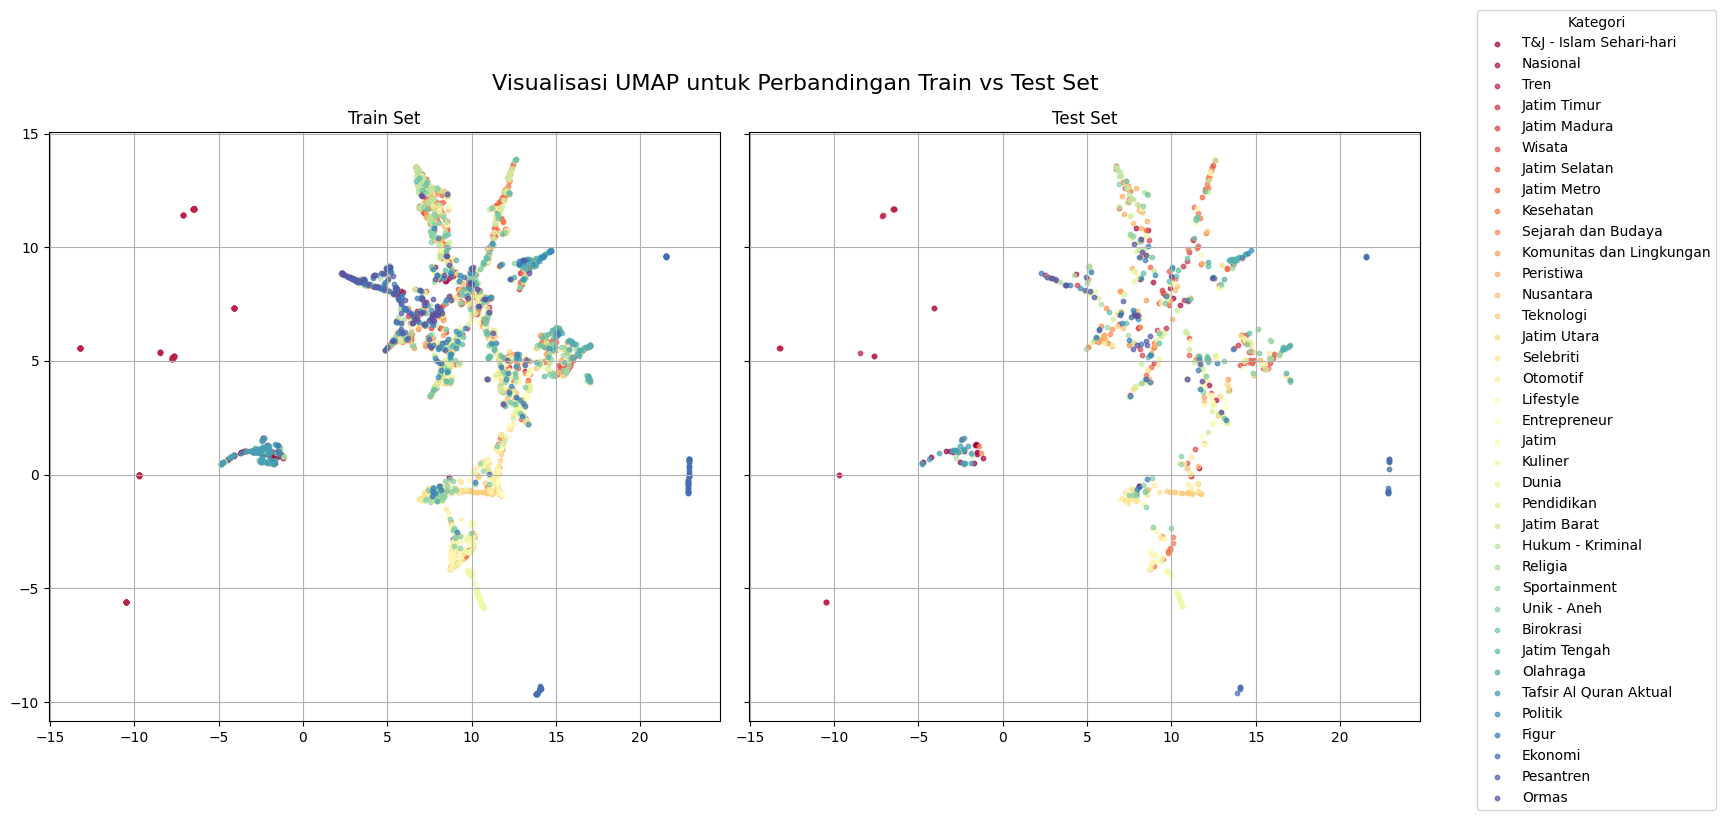

In [29]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler

# Pastikan Anda sudah menjalankan Fase 4 dan memiliki variabel:
# X_train, X_test, y_train, y_test

# --- 1. Siapkan Label dan Pemetaan Warna ---
# Buat daftar label kategori yang unik
labels = list(pd.Series(y_train).unique())
# Buat pemetaan dari nama kategori (string) ke angka (integer) untuk pewarnaan
label_map = {label: i for i, label in enumerate(labels)}

# Terapkan pemetaan ke y_train dan y_test
y_train_numeric = pd.Series(y_train).map(label_map).values
y_test_numeric = pd.Series(y_test).map(label_map).values

# --- 2. Gabungkan, Skalakan, dan Terapkan UMAP (seperti referensi) ---
# Gabungkan data train dan test untuk membuat satu "peta" UMAP
X_combined = np.concatenate((X_train, X_test), axis=0)

# Terapkan StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Inisialisasi dan latih UMAP pada data gabungan yang sudah diskalakan
reducer = umap.UMAP(n_components=2, random_state=42)
X_2d_combined = reducer.fit_transform(X_scaled)

# Pisahkan kembali hasilnya menjadi train dan test
x2d_train = X_2d_combined[:len(X_train)]
x2d_test = X_2d_combined[len(X_train):]

# --- 3. Fungsi untuk Menggambar Plot (diambil dari referensi) ---
def plot_topic_clusters(ax, x2d, y_numeric, labels, title):
    ax.set_title(title)
    # Dapatkan palet warna
    colors = cm.get_cmap("Spectral", len(labels))
    # Gambar scatter plot untuk setiap kategori
    for i, label_name in enumerate(labels):
        ax.scatter(x2d[y_numeric == i, 0], 
                   x2d[y_numeric == i, 1], 
                   color=colors(i / len(labels)), 
                   label=label_name, 
                   alpha=0.7, s=10)
    ax.grid(True)
    return ax

# --- 4. Buat dan Tampilkan Dua Subplot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

# Gambar plot untuk data Train
plot_topic_clusters(axes[0], x2d_train, y_train_numeric, labels, "Train Set")
# Gambar plot untuk data Test
plot_topic_clusters(axes[1], x2d_test, y_test_numeric, labels, "Test Set")

fig.suptitle("Visualisasi UMAP untuk Perbandingan Train vs Test Set", fontsize=16)

# Tambahkan legenda di luar plot agar tidak berantakan
handles, _ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Kategori", loc='center right', bbox_to_anchor=(1.08, 0.5))

plt.tight_layout(rect=[0, 0, 0.9, 1]) # Sesuaikan layout agar legenda tidak terpotong
plt.show()

--- Pembagian Data Selesai ---
Jumlah data latih: 2922
Jumlah data uji: 731

--- Memulai Pelatihan Model SVM ---
--- Pelatihan Model Selesai ---

--- HASIL EVALUASI MODEL ---
Akurasi Model: 36.53%

Laporan Klasifikasi (Classification Report):


c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

                          precision    recall  f1-score   support

               Birokrasi       0.06      0.20      0.09        20
                   Dunia       0.57      0.20      0.30        20
                 Ekonomi       0.95      1.00      0.98        20
            Entrepreneur       0.30      0.80      0.44        20
                   Figur       0.14      0.10      0.12        20
        Hukum - Kriminal       0.36      0.85      0.51        20
                   Jatim       0.20      0.10      0.13        20
             Jatim Barat       0.00      0.00      0.00        20
            Jatim Madura       0.33      0.05      0.09        20
             Jatim Metro       0.60      0.15      0.24        20
           Jatim Selatan       0.00      0.00      0.00        20
            Jatim Tengah       0.40      0.10      0.16        20
             Jatim Timur       0.07      0.05      0.06        20
             Jatim Utara       0.00      0.00      0.00        20
         

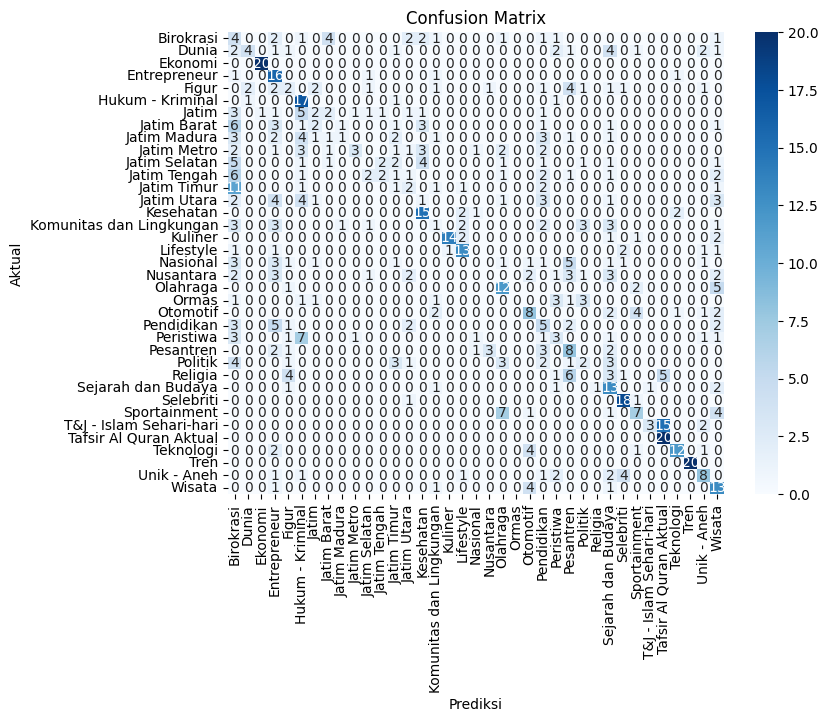

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Membagi Data menjadi Data Latih dan Data Uji ---
# Kita akan membagi data kita: 80% untuk melatih model, 20% untuk menguji performanya.
# 'stratify=y' penting agar proporsi setiap kategori di data latih dan uji tetap sama.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

print("--- Pembagian Data Selesai ---")
print(f"Jumlah data latih: {X_train.shape[0]}")
print(f"Jumlah data uji: {X_test.shape[0]}")


# --- 2. Memilih dan Melatih Model Klasifikasi ---
# Kita akan menggunakan Logistic Regression, model yang bagus dan cepat untuk memulai.
# 'max_iter' mungkin perlu ditingkatkan jika datanya kompleks.
# classifier = LogisticRegression(random_state=42, max_iter=1000)

# # Latih model menggunakan data latih
# print("\n--- Memulai Pelatihan Model ---")
# classifier.fit(X_train, y_train)
# print("--- Pelatihan Model Selesai ---")


# --- Ganti blok kode model di Fase 4 ---
from sklearn.svm import SVC # Import Support Vector Classifier

# Gunakan SVM dengan kernel linear
classifier = SVC(kernel='linear', random_state=42)

# Latih model menggunakan data latih
print("\n--- Memulai Pelatihan Model SVM ---")
classifier.fit(X_train, y_train)
print("--- Pelatihan Model Selesai ---")

# # --- Ganti blok kode model di Fase 4 ---
# from sklearn.naive_bayes import MultinomialNB # Import Naive Bayes

# # Inisialisasi model Naive Bayes
# classifier = MultinomialNB()

# # Latih model menggunakan data latih
# print("\n--- Memulai Pelatihan Model Naive Bayes ---")
# classifier.fit(X_train, y_train)
# print("--- Pelatihan Model Selesai ---")


# --- 3. Melakukan Prediksi pada Data Uji ---
# Sekarang kita gunakan model yang sudah dilatih untuk menebak kategori dari data uji.
y_pred = classifier.predict(X_test)


# --- 4. Mengevaluasi Kinerja Model ---
print("\n--- HASIL EVALUASI MODEL ---")

# Menghitung Akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {accuracy * 100:.2f}%")

# Menampilkan Classification Report (Precision, Recall, F1-Score)
# Ini adalah metrik paling penting untuk melihat performa per kategori.
print("\nLaporan Klasifikasi (Classification Report):")
print(classification_report(y_test, y_pred))


# (Opsional tapi sangat direkomendasikan) Visualisasi Confusion Matrix
# Ini membantu melihat di mana model Anda sering membuat kesalahan.
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(list(set(y))), yticklabels=sorted(list(set(y))))
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()